In [3]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# add src path to the notebook
import os
import sys
PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025a_relevance_classification_2.0


# Analysis of Labelled Data
After labelling all of the data created in the previous notebook, we can now go ahead and look at the spatiotemporal distances of the data to the actual events. To achieve this, we first need to acquire spatial masks for the event.
- [2023 Chile wildfires](https://firms.modaps.eosdis.nasa.gov/map/#m:burned_area;d:2023-01-22..2023-02-01;l:modis_burned_area=[fill|2023|1|2|3|4|5],country-outline,earth;@-71.5,-37.7,7.3z) (v1 via [EMS](https://emergency.copernicus.eu/mapping/list-of-components/EMSR647/), v2 via NASA FIRMS)
- [2021 Germany floods](https://emergency.copernicus.eu/mapping/list-of-components/EMSR517/) (via EMS)
- [2023 Turkey earthquake](https://earthquake.usgs.gov/) (v1 via [GDACS](https://www.gdacs.org/Alerts/default.aspx), v2 via US Geological Survey)
- [2023 Emilia Romagna (Italy) floods](https://geoportale.regione.emilia-romagna.it/approfondimenti/emergenza-maggio-23/emergenza-rer-maggio-2023-servizi) (via regione.emilia-romagna.it)
- [2020 California wildfires](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/explore) (via California state portal)

In [4]:
import ast
import shapely
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from itertools import combinations
from tqdm import tqdm
from src.utils import extract_files_from_zips
sns.set_style('ticks')

# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(f'Data path: {DATA_PATH}')

/home/david/miniconda3/envs/active-learning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data path: /mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025a_relevance_classification_2.0/data


## 1. Event dataset creation
To effectively compute spatial and temporal distances, it makes sense to create a master file with alle necessary event data.
We start off with the 2021 Ahr Valley data.

### 1.1. 2021 Germany floods (EMS)
We need to extract the observed event data from the EMS zipfiles.

In [4]:
extract_files_from_zips(
    zip_folder=os.path.join(DATA_PATH, 'external', 'event_data', '2021_germany_floods', 'ems_delineations'),
    extract_folder=os.path.join(DATA_PATH, 'external', 'event_data', '2021_germany_floods', 'processed'),
    search_string='observedEvent'
)

Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.dbf from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.json from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.kmz from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.prj from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.shp from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.shx from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.sld from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.xml from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.dbf from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.json from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.kmz from EMSR517_bonn.zip
Extracted: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.prj from EMSR517

Subsequently, we need to read them all in and create a proper dataset.

In [28]:
germany_gdfs: list[gpd.GeoDataFrame] = []

# iterate over all extracted shapefiles
extract_folder: str = os.path.join(DATA_PATH, 'external', 'event_data', '2021_germany_floods', 'processed')
for filename in os.listdir(extract_folder):
    if filename.endswith('.shp'):  # Check if file is a shapefile
        file_path = os.path.join(extract_folder, filename)
        gdf: gpd.GeoDataFrame = gpd.read_file(file_path)  # Read shapefile
        gdf['filename'] = filename
        germany_gdfs.append(gdf)
        print(f"Loaded: {filename}, {gdf.shape}")

germany_gdf: gpd.GeoDataFrame = pd.concat(germany_gdfs, ignore_index=True)
print(f"Combined shape: {germany_gdf.shape}")

# add start and end date columns
# definition as per: https://de.wikipedia.org/wiki/Liste_von_Hochwasserereignissen_an_der_Ahr
germany_gdf['start_date'] = pd.to_datetime('2021-07-14')
germany_gdf['end_date'] = pd.to_datetime('2021-07-17')

# store the results
germany_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'ahr_valley', 'ahr_valley_flood_delineation.parquet'))

germany_gdf.head()

Loaded: EMSR517_AOI01_DEL_MONIT01_observedEventA_r1_v1.shp, (98, 8)
Loaded: EMSR517_AOI03_DEL_MONIT01_observedEventA_r1_v1.shp, (93, 8)
Loaded: EMSR517_AOI04_DEL_MONIT01_observedEventA_r1_v1.shp, (489, 8)
Loaded: EMSR517_AOI05_DEL_MONIT01_observedEventA_r1_v1.shp, (722, 8)
Loaded: EMSR517_AOI06_DEL_MONIT01_observedEventA_r1_v1.shp, (591, 8)
Combined shape: (1993, 8)


,event_type,obj_desc,det_method,notation,dmg_src_id,area,geometry,filename,start_date,end_date
0,5-Flood,Riverine flood,Photo-interpretation,Flooded area,4,18.017499,"POLYGON ((7.56074 50.33787, 7.56099 50.33682, ...",EMSR517_AOI01_DEL_MONIT01_observedEventA_r1_v1...,2021-07-14,2021-07-17
1,5-Flood,Riverine flood,Photo-interpretation,Flooded area,4,39.111409,"POLYGON ((7.54333 50.31301, 7.54296 50.31257, ...",EMSR517_AOI01_DEL_MONIT01_observedEventA_r1_v1...,2021-07-14,2021-07-17
2,5-Flood,Riverine flood,Photo-interpretation,Flooded area,4,1.789318,"POLYGON ((7.52818 50.30732, 7.52742 50.30663, ...",EMSR517_AOI01_DEL_MONIT01_observedEventA_r1_v1...,2021-07-14,2021-07-17
3,5-Flood,Riverine flood,Photo-interpretation,Flooded area,4,1.749598,"POLYGON ((7.46261 50.31259, 7.46211 50.31141, ...",EMSR517_AOI01_DEL_MONIT01_observedEventA_r1_v1...,2021-07-14,2021-07-17
4,5-Flood,Riverine flood,Photo-interpretation,Flooded area,4,1.453075,"POLYGON ((7.46417 50.31142, 7.46362 50.31140, ...",EMSR517_AOI01_DEL_MONIT01_observedEventA_r1_v1...,2021-07-14,2021-07-17


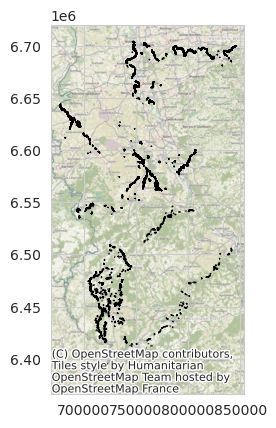

In [29]:
ax = germany_gdf.to_crs(3857).plot(color='k', edgecolor='k')
ctx.add_basemap(ax)

### 1.2. 2023 Chile wildfires (via EMS)
We have also acquired data regarding the 2023 Chile wildfires from the EMS. The processing is analogous.

In [25]:
extract_files_from_zips(
    zip_folder=os.path.join(DATA_PATH, 'external', 'event_data', '2023_chile_wildfires', 'ems_delineations'),
    extract_folder=os.path.join(DATA_PATH, 'external', 'event_data', '2023_chile_wildfires', 'processed'),
    search_string='observedEvent'
)

Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.dbf from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.json from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.kmz from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.prj from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.shp from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.shx from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.sld from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.xml from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventP_r1_v1.dbf from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventP_r1_v1.json from EMSR647_galvarino.zip
Extracted: EMSR647_AOI04_DEL_MONIT04_observedEventP_r1_v1.kmz from EMSR647_galvarino.zip
Extracted: EMSR647_

In [ ]:
# the start and end data needs to be set manually
chile_burns: dict = {
    'AOI01': { 'start_date': '2023-02-13', 'end_date': '2023-02-15'},
    'AOI02': { 'start_date': '2023-02-06', 'end_date': '2023-02-18'},
    'AOI03': { 'start_date': '2023-02-06', 'end_date': '2023-02-06'},
    'AOI04': { 'start_date': '2023-02-06', 'end_date': '2023-02-22'},
    'AOI05': { 'start_date': '2023-02-06', 'end_date': '2023-02-10'},
    'AOI06': { 'start_date': '2023-02-06', 'end_date': '2023-02-16'},
    'AOI07': { 'start_date': '2023-02-06', 'end_date': '2023-02-13'},
}

chile_gdfs: list[gpd.GeoDataFrame] = []

# iterate over all extracted shapefiles
extract_folder: str = os.path.join(DATA_PATH, 'external', 'event_data', '2023_chile_wildfires', 'processed')
for filename in os.listdir(extract_folder):
    if filename.endswith('.shp'):  # Check if file is a shapefile
        file_path = os.path.join(extract_folder, filename)
        gdf: gpd.GeoDataFrame = gpd.read_file(file_path)  # Read shapefile
        gdf['filename'] = filename
        chile_gdfs.append(gdf)
        print(f"Loaded: {filename}, {gdf.shape}")

chile_gdf: gpd.GeoDataFrame = pd.concat(chile_gdfs, ignore_index=True)
print(f"Combined shape: {germany_gdf.shape}")

# add start and end date columns
chile_gdf['start_date'] = pd.NA
chile_gdf['end_date'] = pd.NA
for index, row in chile_gdf.iterrows():
    aoi = row['filename'].split('_')[1]
    chile_gdf.at[index, 'start_date'] = pd.to_datetime(chile_burns[aoi]['start_date'])
    chile_gdf.at[index, 'end_date'] = pd.to_datetime(chile_burns[aoi]['end_date'])

# store the results
chile_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_wildfire_delineation.EMS.parquet'))

chile_gdf.head()

Loaded: EMSR647_AOI01_DEL_MONIT06_observedEventA_r1_v1.shp, (32, 8)
Loaded: EMSR647_AOI02_DEL_MONIT04_observedEventA_r1_v1.shp, (118, 8)
Loaded: EMSR647_AOI04_DEL_MONIT04_observedEventA_r1_v1.shp, (236, 8)
Loaded: EMSR647_AOI04_DEL_MONIT04_observedEventP_r1_v1.shp, (9, 7)
Loaded: EMSR647_AOI05_DEL_MONIT02_observedEventA_r1_v1.shp, (2, 8)
Loaded: EMSR647_AOI06_DEL_MONIT05_observedEventA_r1_v1.shp, (7, 8)
Loaded: EMSR647_AOI07_DEL_MONIT04_observedEventA_r1_v1.shp, (58, 8)
Combined shape: (1993, 10)


,event_type,obj_desc,det_method,notation,dmg_src_id,area,geometry,filename,start_date,end_date
0,8-Wildfire,Forest Fire,Photo-interpretation,Burnt area,8,12.540668,"POLYGON ((-72.82373 -37.46707, -72.82430 -37.4...",EMSR647_AOI01_DEL_MONIT06_observedEventA_r1_v1...,2023-02-13 00:00:00,2023-02-15 00:00:00
1,8-Wildfire,Forest Fire,Photo-interpretation,Burnt area,8,0.991298,"POLYGON ((-72.77617 -37.44245, -72.77634 -37.4...",EMSR647_AOI01_DEL_MONIT06_observedEventA_r1_v1...,2023-02-13 00:00:00,2023-02-15 00:00:00
2,8-Wildfire,Forest Fire,Photo-interpretation,Burnt area,8,0.866880,"POLYGON ((-72.65766 -37.75008, -72.65796 -37.7...",EMSR647_AOI01_DEL_MONIT06_observedEventA_r1_v1...,2023-02-13 00:00:00,2023-02-15 00:00:00
3,8-Wildfire,Forest Fire,Photo-interpretation,Burnt area,8,14.221801,"POLYGON ((-72.66202 -37.74833, -72.66164 -37.7...",EMSR647_AOI01_DEL_MONIT06_observedEventA_r1_v1...,2023-02-13 00:00:00,2023-02-15 00:00:00
4,8-Wildfire,Forest Fire,Photo-interpretation,Burnt area,8,179.093964,"POLYGON ((-72.64055 -37.73598, -72.64123 -37.7...",EMSR647_AOI01_DEL_MONIT06_observedEventA_r1_v1...,2023-02-13 00:00:00,2023-02-15 00:00:00


In [6]:
chile_gdf: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'external', 'event_data', '2023_chile_wildfires', 
                                                            'NASA_firms', 'firms_modis_chile_fire_archive_M-C61_594828.shp'))
pd.DataFrame(chile_gdf)

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,-40.0486,-73.1029,310.2,2.1,1.4,2023-01-01,0300,Terra,MODIS,79,61.03,283.2,35.7,N,0,POINT (-73.10290 -40.04860)
1,-40.0270,-73.1554,318.0,2.1,1.4,2023-01-01,0300,Terra,MODIS,96,61.03,283.2,55.6,N,0,POINT (-73.15540 -40.02700)
2,-40.0269,-73.1609,313.2,2.1,1.4,2023-01-01,0300,Terra,MODIS,87,61.03,282.6,43.5,N,0,POINT (-73.16090 -40.02690)
3,-40.0250,-73.1371,300.7,2.1,1.4,2023-01-01,0300,Terra,MODIS,22,61.03,283.8,19.0,N,0,POINT (-73.13710 -40.02500)
4,-37.0442,-72.3925,309.6,1.7,1.3,2023-01-01,0301,Terra,MODIS,78,61.03,286.8,25.3,N,2,POINT (-72.39250 -37.04420)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13722,-22.3129,-68.8824,311.8,1.3,1.1,2023-06-30,1412,Terra,MODIS,66,61.03,290.6,11.4,D,2,POINT (-68.88240 -22.31290)
13723,-35.0963,-71.9109,308.2,1.2,1.1,2023-06-30,1416,Terra,MODIS,67,61.03,285.8,14.7,D,0,POINT (-71.91090 -35.09630)
13724,-26.4364,-69.4858,316.3,1.0,1.0,2023-06-30,1843,Aqua,MODIS,68,61.03,304.5,6.5,D,2,POINT (-69.48580 -26.43640)
13725,-26.4350,-69.4758,320.5,1.0,1.0,2023-06-30,1843,Aqua,MODIS,74,61.03,304.7,10.2,D,2,POINT (-69.47580 -26.43500)


In [23]:
chile_gdf: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'external', 'event_data', '2023_chile_wildfires', 
                                                            'NASA_firms', 'firms_modis_chile_fire_archive_M-C61_594828.shp'))
chile_gdf['start_date'] = pd.to_datetime(chile_gdf['ACQ_DATE'])
chile_gdf['end_date'] = pd.to_datetime(chile_gdf['ACQ_DATE'])

# store the results
chile_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_wildfire_delineation.parquet'))

print(chile_gdf.shape)
chile_gdf.head()

(13727, 18)


,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry,start_date,end_date
0,-40.0486,-73.1029,310.2,2.1,1.4,2023-01-01,0300,Terra,MODIS,79,61.03,283.2,35.7,N,0,POINT (-73.10290 -40.04860),2023-01-01,2023-01-01
1,-40.0270,-73.1554,318.0,2.1,1.4,2023-01-01,0300,Terra,MODIS,96,61.03,283.2,55.6,N,0,POINT (-73.15540 -40.02700),2023-01-01,2023-01-01
2,-40.0269,-73.1609,313.2,2.1,1.4,2023-01-01,0300,Terra,MODIS,87,61.03,282.6,43.5,N,0,POINT (-73.16090 -40.02690),2023-01-01,2023-01-01
3,-40.0250,-73.1371,300.7,2.1,1.4,2023-01-01,0300,Terra,MODIS,22,61.03,283.8,19.0,N,0,POINT (-73.13710 -40.02500),2023-01-01,2023-01-01
4,-37.0442,-72.3925,309.6,1.7,1.3,2023-01-01,0301,Terra,MODIS,78,61.03,286.8,25.3,N,2,POINT (-72.39250 -37.04420),2023-01-01,2023-01-01


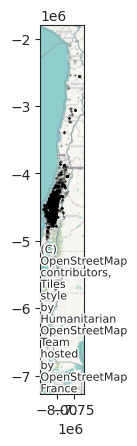

In [10]:
ax = chile_gdf.to_crs(3857).plot(color='k', edgecolor='k', markersize=0.1, alpha=0.3)
ctx.add_basemap(ax)

### 1.3. 2023 Turkey earthquake
We acquired the main alert sites for the Turkey earthquake from GDACS.

In [ ]:
turkey_gdfs: list[gpd.GeoDataFrame] = []

# iterate over all extracted shapefiles
extract_folder: str = os.path.join(DATA_PATH, 'external', 'event_data', '2023_turkey_earthquake', 'gdacs_alerts')
for filename in os.listdir(extract_folder):
    if filename.endswith('.geojson'):  # Check if file is a shapefile
        file_path = os.path.join(extract_folder, filename)
        gdf: gpd.GeoDataFrame = gpd.read_file(file_path)  # Read shapefile
        gdf['filename'] = filename
        turkey_gdfs.append(gdf)
        print(f"Loaded: {filename}, {gdf.shape}")

turkey_gdf: gpd.GeoDataFrame = pd.concat(turkey_gdfs, ignore_index=True)
print(f"Combined shape: {germany_gdf.shape}")

# rename date columns
turkey_gdf.rename(columns={'fromdate': 'start_date', 'todate': 'end_date'}, inplace=True)

# store the results
turkey_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_earthquake_impact_sites.GDACS.parquet'))

turkey_gdf.head()

Loaded: gdacs_turkey_20230206_M6.7_orange.geojson, (1, 37)
Loaded: gdacs_turkey_20230206_M6_orange.geojson, (1, 37)
Loaded: gdacs_turkey_20230206_M7.5_red.geojson, (1, 37)
Loaded: gdacs_turkey_20230206_M7.8_red.geojson, (1, 37)
Loaded: gdacs_turkey_20230220_M6.3_orange.geojson, (1, 37)
Combined shape: (1993, 10)


,eventtype,eventid,episodeid,eventname,glide,name,description,htmldescription,icon,iconoverall,url,alertlevel,alertscore,episodealertlevel,episodealertscore,istemporary,iscurrent,country,start_date,end_date,datemodified,iso3,source,sourceid,polygonlabel,Class,affectedcountries,severitydata,episodes,impacts,images,additionalinfos,earthquakedetails,documents,shakemap,geometry,filename
0,EQ,1357374,1487207,,EQ-2023-000015-TUR,Earthquake in Türkiye,Earthquake in Türkiye,Orange M 6.7 Earthquake in Türkiye at: 06 Feb ...,https://www.gdacs.org/images/gdacs_icons/maps/...,None,{'geometry': 'https://www.gdacs.org/gdacsapi/a...,Orange,2,Orange,1.066687,false,false,Türkiye,2023-02-06 01:28:17,2023-02-06 01:28:17,2023-02-23 01:03:21,TUR,NEIC,us6000jlm1,Centroid,Point_Centroid,"[ { ""iso3"": ""TUR"", ""countryname"": ""Türkiye"" } ]","{'severity': 6.7, 'severitytext': 'Magnitude 6...","[ { ""details"": ""https:\/\/www.gdacs.org\/gdacs...","[ { ""source"": ""NEIC"", ""resource"": { ""impact"": ...",{'neic': 'http://earthquake.usgs.gov/eqcenter/...,"{'hasmeteo': 'true', 'meteotrigger': 'false'}","{'country': 'Türkiye', 'depth': '14.497', 'epi...",{},"[ { ""shakeid"": 7, ""conditions"": ""depth=10.7;la...",POINT (36.94260 37.12720),gdacs_turkey_20230206_M6.7_orange.geojson
1,EQ,1357591,1487359,,EQ-2023-000015-TUR,Earthquake in Türkiye,Earthquake in Türkiye,Orange M 6 Earthquake in Türkiye at: 06 Feb 20...,https://www.gdacs.org/images/gdacs_icons/maps/...,None,{'geometry': 'https://www.gdacs.org/gdacsapi/a...,Orange,2,Orange,1.372144,false,false,Türkiye,2023-02-06 12:02:11,2023-02-06 12:02:11,2023-02-25 16:03:01,TUR,NEIC,us6000jlrc,Centroid,Point_Centroid,"[ { ""iso3"": ""TUR"", ""countryname"": ""Türkiye"" } ]","{'severity': 6.0, 'severitytext': 'Magnitude 6...","[ { ""details"": ""https:\/\/www.gdacs.org\/gdacs...","[ { ""source"": ""NEIC"", ""resource"": { ""impact"": ...",{'neic': 'http://earthquake.usgs.gov/eqcenter/...,"{'hasmeteo': 'true', 'meteotrigger': 'false'}","{'country': 'Türkiye', 'depth': '10', 'episode...",{},"[ { ""shakeid"": 4, ""conditions"": ""depth=10;lati...",POINT (36.53700 38.06050),gdacs_turkey_20230206_M6_orange.geojson
2,EQ,1357560,1487318,,EQ-2023-000015-TUR,Earthquake in Türkiye,Earthquake in Türkiye,Red M 7.5 Earthquake in Türkiye at: 06 Feb 202...,https://www.gdacs.org/images/gdacs_icons/maps/...,None,{'geometry': 'https://www.gdacs.org/gdacsapi/a...,Red,3,Red,2.178192,false,false,Türkiye,2023-02-06 10:24:49,2023-02-06 10:24:49,2023-02-28 11:05:33,TUR,NEIC,us6000jlqa,Centroid,Point_Centroid,"[ { ""iso3"": ""TUR"", ""countryname"": ""Türkiye"" } ]","{'severity': 7.5, 'severitytext': 'Magnitude 7...","[ { ""details"": ""https:\/\/www.gdacs.org\/gdacs...","[ { ""source"": ""NEIC"", ""resource"": { ""impact"": ...",{'neic': 'http://earthquake.usgs.gov/eqcenter/...,"{'hasmeteo': 'true', 'meteotrigger': 'false'}","{'country': 'Türkiye', 'depth': '10', 'episode...",{'121097_DroughtReport_Turkiye_Syria_20230210_...,"[ { ""shakeid"": 8, ""conditions"": ""depth=10;lati...",POINT (37.20300 38.02350),gdacs_turkey_20230206_M7.5_red.geojson
3,EQ,1357372,1487096,,EQ-2023-000015-TUR,Earthquake in Türkiye,Earthquake in Türkiye,Red M 7.8 Earthquake in Türkiye at: 06 Feb 202...,https://www.gdacs.org/images/gdacs_icons/maps/...,None,{'geometry': 'https://www.gdacs.org/gdacsapi/a...,Red,3,Red,4.868277,false,false,Türkiye,2023-02-06 01:17:35,2023-02-06 01:17:35,2023-04-20 11:00:19,TUR,NEIC,us6000jllz,Centroid,Point_Centroid,"[ { ""iso3"": ""TUR"", ""countryname"": ""Türkiye"" } ]","{'severity': 7.8, 'severitytext': 'Magnitude 7...","[ { ""details"": ""https:\/\/www.gdacs.org\/gdacs...","[ { ""source"": ""NEIC"", ""resource"": { ""impact"": ...",{'neic': 'http://earthquake.usgs.gov/eqcenter/...,"{'hasmeteo': 'true', 'meteotrigger': 'false'}","{'country': 'Türkiye', 'depth': '17.925', 'epi...",{},"[ { ""shakeid"": 9, ""conditions"": ""depth=17.9;la...",POINT (37.03200 37.17360),gdacs_turkey_20230206_M7.8_red.geojson
4,EQ,1360964,149112

In [26]:
turkey_gdf: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'external', 'event_data', '2023_turkey_earthquake',
                                                          'usgs_turkey_earthquake.geojson'))
turkey_gdf['start_date'] = pd.to_datetime(turkey_gdf['time'], unit='ms')
turkey_gdf['end_date'] = pd.to_datetime(turkey_gdf['start_date'])
turkey_gdf.to_crs(4326, inplace=True)

# store the new dataframe
turkey_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_earthquake_impact_sites.parquet'))

pd.DataFrame(turkey_gdf)

,id,mag,place,time,updated,tz,url,detail,felt,cdi,...,nst,dmin,rms,gap,magType,type,title,geometry,start_date,end_date
0,us6000jn5q,4.2,eastern Turkey,1676059967019,1681594795040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,48,0.638,0.81,50,mb,earthquake,M 4.2 - eastern Turkey,POINT Z (38.58480 38.05170 10.00000),2023-02-10 20:12:47.019,2023-02-10 20:12:47.019
1,us6000jn4x,4.1,"15 km N of Sincik, Turkey",1676050284653,1681594795040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,60,0.758,0.53,41,mwr,earthquake,"M 4.1 - 15 km N of Sincik, Turkey",POINT Z (38.59810 38.17880 4.25800),2023-02-10 17:31:24.653,2023-02-10 17:31:24.653
2,us6000jn4r,4.7,"21 km ESE of Saimbeyli, Turkey",1676048451366,1681594795040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,3.0,5.2,...,128,0.309,0.72,34,mwr,earthquake,"M 4.7 - 21 km ESE of Saimbeyli, Turkey",POINT Z (36.29510 37.88680 2.08700),2023-02-10 17:00:51.366,2023-02-10 17:00:51.366
3,us6000jn2a,4.4,"14 km SW of Ye?ilyurt, Turkey",1676023280828,1681594793040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,44,0.907,0.72,44,mb,earthquake,"M 4.4 - 14 km SW of Ye?ilyurt, Turkey",POINT Z (38.13750 38.19760 10.00000),2023-02-10 10:01:20.828,2023-02-10 10:01:20.828
4,us6000jn1b,4.3,"7 km NW of Çelikhan, Turkey",1676019769022,1681594793040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,57,0.815,0.33,49,mb,earthquake,"M 4.3 - 7 km NW of Çelikhan, Turkey",POINT Z (38.17560 38.07570 7.34500),2023-02-10 09:02:49.022,2023-02-10 09:02:49.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,us6000jnr5,4.7,"14 km SSW of A?a?? Karafak?l?, Turkey",1675647648558,1681594799040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,17,0.772,0.51,227,mb,earthquake,"M 4.7 - 14 km SSW of A?a?? Karafak?l?, Turkey",POINT Z (36.47670 36.66960 10.00000),2023-02-06 01:40:48.558,2023-02-06 01:40:48.558
346,us6000jlm9,5.6,Turkey-Syria border region,1675647387357,1681594773040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,6.0,4.8,...,167,0.458,0.59,47,mb,earthquake,M 5.6 - Turkey-Syria border region,POINT Z (36.68320 36.99210 10.00000),2023-02-06 01:36:27.357,2023-02-06 01:36:27.357
347,us6000jlm1,6.7,"14 km E of Nurda??, Turkey",1675646895784,1695413360631,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,127.0,7.9,...,194,0.254,0.68,19,mww,earthquake,"M 6.7 - 14 km E of Nurda??, Turkey",POINT Z (36.89290 37.18930 9.79700),2023-02-06 01:28:15.784,2023-02-06 01:28:15.784
348,us6000jlnn,5.7,"24 km ENE of Nurda??, Turkey",1675646810869,1728494166477,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,94,0.175,1.32,75,mb,earthquake,"M 5.7 - 24 km ENE of Nurda??, Turkey",POINT Z (37.00010 37.22520 10.00000),2023-02-06 01:26:50.869,2023-02-06 01:26:50.869


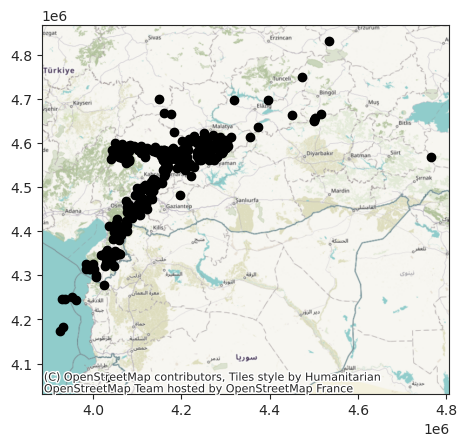

In [20]:
ax = turkey_gdf.to_crs(3857).plot(color='k', edgecolor='k')
ctx.add_basemap(ax)

### 1.4. 2023 Italy floods
We also need to read in the data regarding the italy floods.

In [30]:
# https://en.wikipedia.org/wiki/2023_Emilia-Romagna_floods
# there are two parts of the flood event
italy_part_1: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'external', 'event_data', '2023_italy_floods', 'perimetrazioni_2023_zone_v5_ev1_pb_pl.shp'))
italy_part_1['start_date'] = pd.to_datetime('2023-05-02')
italy_part_1['end_date'] = pd.to_datetime('2023-05-03')

italy_part_2: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'external', 'event_data', '2023_italy_floods', 'perimetrazioni_2023_zone_v5_ev2_pb_pl.shp')).rename(columns={'AREA': 'area', 'perimetro': 'perimeter'})
italy_part_2['start_date'] = pd.to_datetime('2023-05-16')
italy_part_2['end_date'] = pd.to_datetime('2023-05-17')

italy_gdf: gpd.GeoDataFrame = pd.concat([
    italy_part_1, italy_part_2    
])
print(italy_gdf.shape)

# fix index
italy_gdf.reset_index(inplace=True, drop=True)

# store the results
italy_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_flood_delineation.parquet'))

italy_gdf

(2167, 8)


,fid,evento,area,perimeter,gid,geometry,start_date,end_date
0,1.0,Evento 03/05/2023,6.545835e+03,445.396640,1,"POLYGON ((709264.900 4911423.556, 709254.165 4...",2023-05-02,2023-05-03
1,2.0,Evento 03/05/2023,1.894344e+05,5135.434868,2,"POLYGON ((716682.780 4913784.136, 716531.768 4...",2023-05-02,2023-05-03
2,3.0,Evento 03/05/2023,3.363776e+04,1565.113838,3,"POLYGON ((712464.502 4921903.418, 712372.258 4...",2023-05-02,2023-05-03
3,4.0,Evento 03/05/2023,1.829047e+05,3531.827468,4,"POLYGON ((713594.529 4922327.957, 713660.022 4...",2023-05-02,2023-05-03
4,5.0,Evento 03/05/2023,4.855902e+04,1140.559776,5,"POLYGON ((713744.153 4922917.500, 713711.413 4...",2023-05-02,2023-05-03
...,...,...,...,...,...,...,...,...
2162,16.0,Evento 16/05/2023,3.464080e+05,4803.000000,16,"POLYGON ((742291.980 4900252.713, 742303.246 4...",2023-05-16,2023-05-17
2163,18.0,Evento 16/05/2023,1.055369e+06,10339.000000,18,"POLYGON ((743095.126 4902076.949, 743089.644 4...",2023-05-16,2023-05-17
2164,11.0,Evento 16/05/2023,1.325350e+05,2464.000000,11,"POLYGON ((740751.247 4894148.680, 740744.106 4...",2023-05-16,2023-05-17
2165,1573.0,Evento 16/05/2023,6.515770e+05,4413.000000,1573,"POLYGON ((748390.003 4905670.424, 748397.859 4...",2023-05-16,2023-05-17


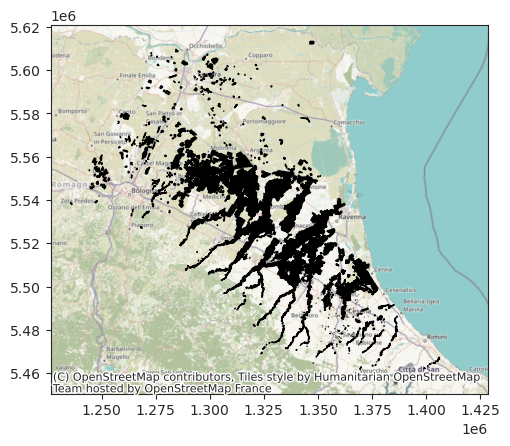

In [31]:
ax = italy_gdf.to_crs(3857).plot(color='k', edgecolor='k')
ctx.add_basemap(ax)

### 1.5. 2020 California wildfires
Lastly, we prepare the burn data for the 2020 california wildfires.

In [29]:
california_gdf: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'external', 'event_data', '2020_california_wildfires', 'California_Fire_Perimeters_(all).geojson'))

# only filter for 2020
california_gdf = california_gdf[california_gdf['YEAR_'] == 2020]
california_gdf.rename(columns={'ALARM_DATE': 'start_date', 'CONT_DATE': 'end_date'}, inplace=True) # note: CONT_DATE = Containment Date
print(california_gdf.shape)

# remove timezone information
california_gdf['start_date'] = california_gdf['start_date'].dt.tz_localize(None)
california_gdf['end_date'] = california_gdf['end_date'].dt.tz_localize(None)

# store the results
california_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'california', 'california_burn_delineation.parquet'))

california_gdf.head()

(505, 22)


,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,start_date,end_date,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,geometry
978,979,2020.0,CA,CDF,NEU,NELSON,00013212,2020-06-18,2020-06-23,11.0,...,109.60230,,None,{38066BE5-68E5-435B-B8D7-451E38196E15},None,None,2020.0,7.331347e+05,4179.743142,"POLYGON ((-121.34842 38.88999, -121.34836 38.8..."
979,980,2020.0,CA,CDF,NEU,AMORUSO,00011799,2020-06-01,2020-06-04,2.0,...,685.58500,,None,{75ACF0A2-FBCF-4BC6-AF99-BB28865C3F95},None,None,2020.0,4.578172e+06,12399.375391,"POLYGON ((-121.35276 38.82039, -121.35269 38.8..."
980,981,2020.0,CA,CDF,NEU,ATHENS,00018493,2020-08-10,2020-08-11,14.0,...,27.30048,,None,{AFBF4DA8-2238-4B48-889D-29363B74DC5F},None,None,2020.0,1.823876e+05,2119.194120,"POLYGON ((-121.33335 38.84558, -121.33312 38.8..."
981,982,2020.0,CA,CDF,NEU,FLEMING,00007619,2020-03-31,2020-04-01,9.0,...,12.93155,,None,,None,None,2020.0,8.667945e+04,2029.524881,"POLYGON ((-121.27318 38.96308, -121.27306 38.9..."
982,983,2020.0,CA,CDF,NEU,MELANESE,00008471,2020-04-14,2020-04-19,18.0,...,10.31596,,None,{DDC3C7A0-29A9-4FD9-8FE5-92F2FE31D283},None,None,2020.0,7.017913e+04,1342.742903,"POLYGON ((-121.30067 39.48714, -121.30042 39.4..."


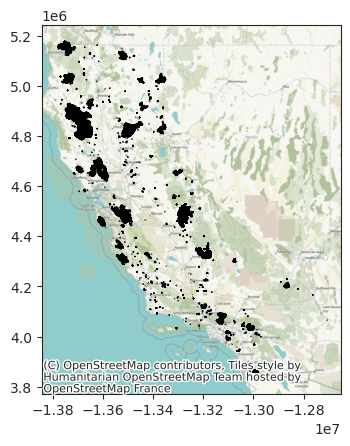

In [32]:
ax = california_gdf.to_crs(3857).plot(color='k', edgecolor='k')
ctx.add_basemap(ax)

### 1.6. Re-labelling
Based on the our use-case data, we need to go ahead and re-label our training/test data to reflect the spatio-temporal nature of disaster relevance. To achieve this, we prepare a GeoDataFrame that we then load into QGIS.

In [ ]:
relevance_tweets: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_tweets_labelled.v1.csv'))
relevance_tweets['date'] = pd.to_datetime(relevance_tweets['date'])
print(relevance_tweets.shape)

# let's ditch the tweets with reference to another disaster
relevance_tweets = relevance_tweets[relevance_tweets['other_disaster'].isna()]

# overview of the data distribution
print(relevance_tweets.groupby(['use_case', LABEL_COLUMN]).size())

# restore geometries
relevance_tweets['geometry'] = relevance_tweets['geometry'].apply(ast.literal_eval)
relevance_tweets['geometry'] = gpd.GeoSeries.from_wkb(relevance_tweets['geometry'], crs=4326)
# relevance_tweets['centroid'] = relevance_tweets['centroid'].apply(ast.literal_eval)
# relevance_tweets['centroid'] = gpd.GeoSeries.from_wkb(relevance_tweets['centroid'], crs=3857).to_crs(4326)
relevance_tweets: gpd.GeoDataFrame = gpd.GeoDataFrame(relevance_tweets, geometry='geometry', crs=4326)

# store the GeoDataFrame
relevance_tweets.to_file(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_tweets_to_label.v2.QGIS.gpkg'))

# add centroid geometry
relevance_tweets['centroid'] = relevance_tweets['centroid'].apply(ast.literal_eval)
relevance_tweets['centroid'] = gpd.GeoSeries.from_wkb(relevance_tweets['centroid'], crs=3857)

# prepare for further filtering
relevance_tweets.rename(columns={LABEL_COLUMN: 'human_label_text'}, inplace=True)

print(relevance_tweets.shape)
pd.DataFrame(relevance_tweets)

(4746, 17)
use_case      human_label             
California 🔥  Not related                 381
              Related and relevant        324
              Related but not relevant    335
Chile 🔥       Not related                 397
              Related and relevant        156
              Related but not relevant    371
Germany 🌊     Not related                 345
              Related and relevant        239
              Related but not relevant    445
Italy 🌊       Not related                 199
              Related and relevant        169
              Related but not relevant    174
Turkey 🪨      Not related                 309
              Related and relevant        338
              Related but not relevant    395
dtype: int64
(4577, 17)


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,centroid,x,y,text_translated,prev_category,gpt_4o_mini_label,human_label_text,other_disaster
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.33042 -34.62042),NaN,@sanchezzdiegoo Quíhuboo,0,POINT (-7606507.783 -4112416.698),-7606507.783,-4112416.698,@user Quíhuboo,NaN,Not related,Not related,NaN
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86669 -32.88334),NaN,Cómo extraño ir a la aristides a ver los parti...,0,POINT (-7666204.585 -3879829.849),-7666204.585,-3879829.849,How I miss going to Aristides to watch the gam...,NaN,Not related,Not related,NaN
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39758 -35.96602),NaN,Es un robo de agua pohhhhhhh,1,POINT (-7947942.472 -4295946.371),-7947942.472,-4295946.371,"It's a water theft, pohhhhhhh",NaN,Not related,Not related,NaN
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63852 -33.36638),NaN,@anakarinagcm Temazo ese,0,POINT (-7863444.522 -3944036.301),-7863444.522,-3944036.301,@user That's a great song,NaN,Not related,Not related,NaN
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77819 -28.46600),NaN,La primer grieta del 2023 en Catamarca está en...,1,POINT (-7322394.226 -3307853.847),-7322394.226,-3307853.847,The first crack of 2023 in Catamarca is in: - ...,NaN,Not related,Not related,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,"POLYGON ((38.08934 38.16121, 38.08934 38.51397...",NaN,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,POINT (4277176.141 4627256.526),4277176.141,4627256.526,"The Sahara Animal Hospital, established by HAY...",NaN,Related and relevant,Related and relevant,NaN
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,"POLYGON ((32.38223 37.73869, 32.38223 38.00138...",NaN,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,POINT (3619077.241 4561098.719),3619077.241,4561098.719,Yıldız Şahin cannot be found in the rubble. Se...,NaN,Related and relevant,Related and relevant,NaN
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,"POLYGON ((32.64333 39.91044, 32.64333 40.02476...",NaN,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,POINT (3645125.223 4861238.660),3645125.223,4861238.660,@user Academician Yusuf Buğra DOĞAN We can't r...,NaN,Related and relevant,Related and relevant,NaN
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,"POLYGON ((32.78358 39.95773, 32.78358 40.04321...",NaN,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,POINT (3655947.704 4866011.941),3655947.704,4866011.941,If there are families in Diyarbakır Malatya Ka...,NaN,Related and relevant,Related and relevant,NaN


We also need to consider space and time during labelling. A post can probably not be relevant if it was posted:
- $>7$ days before the first disaster (except Turkey)?
- $>30$ after the last disaster?

Furthermore, only posts within a certain distance to the disaster should be considered. To realise this, we evaluate different thresholds:
- 20km
- 50km
- 100km

In [4]:
# reproject such that we can compute distances
relevance_tweets = relevance_tweets.to_crs(epsg=3857)

def compute_height(geom):
    # If the geometry is a point, return 0
    if geom.geom_type == 'Point':
        return 0
    # Use the geometry's bounding box: (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = geom.bounds
    return maxy - miny

# Compute the "height" (north to south) for each geometry and store in a new column (in meters)
relevance_tweets['geom_height'] = relevance_tweets.geometry.apply(compute_height)

# Identify the rows where the north-to-south distance is greater than 500 km (500,000 meters)
large_geoms: pd.Series = relevance_tweets[relevance_tweets['geom_height'] > 500000].index

# Display the result (or further process as needed)
print(f"Number of geometries with height > 500km: {len(large_geoms)}")
print(large_geoms)

# remove the large geometries
relevance_tweets = relevance_tweets.drop(index=large_geoms)

# Project back to 4326
relevance_tweets = relevance_tweets.to_crs(epsg=4326)
print(relevance_tweets.shape)

Number of geometries with height > 500km: 3
Index([1403, 1689, 1796], dtype='int64')
(4574, 18)


Next, we can go ahead and apply spatial and temporal filtering, changing labels from the "Related and relevant" class to "Related but not relevant".

In [5]:
# Setting variables
MAX_DAYS_AFTER_DISASTER: int = 30
MAX_DAYS_BEFORE_DISASTER: int = 7
MAX_DISTANCES_KM: list[int] = [20, 50, 100]

# germany floods
germany_floods: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'ahr_valley', 'ahr_valley_flood_delineation.parquet')
).to_crs('ESRI:102031')  # equidistant Europe
italy_floods: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_flood_delineation.parquet')
).to_crs('ESRI:102031')  # equidistant Europe
turkey_earthquake: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_earthquake_impact_sites.parquet')
).to_crs('ESRI:102031')  # equidistant Europe
chile_wildfires: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_wildfire_delineation.parquet')
).to_crs('ESRI:102032')  # equidistant South America
california_wildfires: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'california', 'california_burn_delineation.parquet')
).to_crs('ESRI:102010')  # equidistant North America

In [8]:
# For each threshold
for distance_threshold in MAX_DISTANCES_KM:
    relevance_tweets[f'human_label_{distance_threshold}km'] = relevance_tweets['human_label_text']

    # go through each row of my event data
    for index, row in tqdm(relevance_tweets.iterrows(), total=relevance_tweets.shape[0]):
        # "Downgrade" rows with date 7 days before the event (except for Turkey)
        if row['use_case'] == 'Turkey 🪨':
            if row['date'] < (first_date - pd.Timedelta(days=1)):
                relevance_tweets.at[index, f'human_label_{distance_threshold}km'] = 'Not related'
        else:
            if row['date'] < (first_date - pd.Timedelta(days=MAX_DAYS_BEFORE_DISASTER)):
                relevance_tweets.at[index, f'human_label_{distance_threshold}km'] = 'Not related'

        # If other class than "Related and relevant", no need to do anything
        if row['human_label_text'] != 'Related and relevant':
            continue

        # depending on the use case, we project our data differently and use a different event data set
        if row['use_case'] == 'Chile 🔥':
            relevance_tweets = relevance_tweets.to_crs('ESRI:102032')  # equidistant South America
            event_gdf = chile_wildfires
        elif row['use_case'] == 'Germany 🌊':
            relevance_tweets = relevance_tweets.to_crs('ESRI:102031')  # equidistant Europe
            event_gdf = germany_floods
        elif row['use_case'] == 'California 🔥':
            relevance_tweets = relevance_tweets.to_crs('ESRI:102010')  # equidistant North America
            event_gdf = california_wildfires
        elif row['use_case'] == 'Italy 🌊':
            relevance_tweets = relevance_tweets.to_crs('ESRI:102031')  # equidistant Europe
            event_gdf = italy_floods
        elif row['use_case'] == 'Turkey 🪨':
            relevance_tweets = relevance_tweets.to_crs('ESRI:102031')  # equidistant Europe
            event_gdf = turkey_earthquake

        # Compute the first (earliest start_date) and last (latest end_date) event dates
        first_date = event_gdf['start_date'].min()
        last_date = event_gdf['end_date'].max()

        # Extract tweet geometry and compute spatial distances
        tweet_geom: gpd.GeoSeries = relevance_tweets.loc[index]['geometry']
        spatial_distances: pd.Series = event_gdf.distance(tweet_geom)

        # "Downgrade" rows with date 30 days after the event
        if row['date'] > (last_date + pd.Timedelta(days=MAX_DAYS_AFTER_DISASTER)):
            relevance_tweets.at[index, f'human_label_{distance_threshold}km'] = 'Related but not relevant'

        # "Downgrade rows" that do not intersect with the buffered event
        if spatial_distances.min() > (distance_threshold * 1000):
            relevance_tweets.at[index, f'human_label_{distance_threshold}km'] = 'Related but not relevant'

relevance_tweets = relevance_tweets.to_crs(4326)
print(relevance_tweets.groupby('human_label_100km').size())
relevance_tweets.to_parquet(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_tweets_labelled.v2.parquet'))
pd.DataFrame(relevance_tweets)

100%|██████████| 4574/4574 [00:15<00:00, 300.92it/s] 

human_label_100km
Not related                 1646
Related and relevant         993
Related but not relevant    1935
dtype: int64


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,centroid,...,y,text_translated,prev_category,gpt_4o_mini_label,human_label_text,other_disaster,geom_height,human_label_20km,human_label_50km,human_label_100km
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32842 -34.61915),NaN,@sanchezzdiegoo Quíhuboo,0,POINT (-7606507.783 -4112416.698),...,-4112416.698,@user Quíhuboo,NaN,Not related,Not related,NaN,0.000000,Not related,Not related,Not related
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86472 -32.88208),NaN,Cómo extraño ir a la aristides a ver los parti...,0,POINT (-7666204.585 -3879829.849),...,-3879829.849,How I miss going to Aristides to watch the gam...,NaN,Not related,Not related,NaN,0.000000,Not related,Not related,Not related
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39556 -35.96501),NaN,Es un robo de agua pohhhhhhh,1,POINT (-7947942.472 -4295946.371),...,-4295946.371,"It's a water theft, pohhhhhhh",NaN,Not related,Not related,NaN,0.000000,Not related,Not related,Not related
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63658 -33.36536),NaN,@anakarinagcm Temazo ese,0,POINT (-7863444.522 -3944036.301),...,-3944036.301,@user That's a great song,NaN,Not related,Not related,NaN,0.000000,Not related,Not related,Not related
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77635 -28.46470),NaN,La primer grieta del 2023 en Catamarca está en...,1,POINT (-7322394.226 -3307853.847),...,-3307853.847,The first crack of 2023 in Catamarca is in: - ...,NaN,Not related,Not related,NaN,0.000000,Not related,Not related,Not related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,"POLYGON ((38.08877 38.15821, 38.08876 38.51099...",NaN,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,POINT (4277176.141 4627256.526),...,4627256.526,"The Sahara Animal Hospital, established by HAY...",NaN,Related and relevant,Related and relevant,NaN,50063.815556,Related and relevant,Related and relevant,Related and relevant
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,"POLYGON ((32.38123 37.73561, 32.38123 37.99831...",NaN,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,POINT (3619077.241 4561098.719),...,4561098.719,Yıldız Şahin cannot be found in the rubble. Se...,NaN,Related and relevant,Related and relevant,NaN,37043.522240,Related but not relevant,Related but not relevant,Related but not relevant
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,"POLYGON ((32.64230 39.90750, 32.64230 40.02184...",NaN,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,POINT (3645125.223 4861238.660),...,4861238.660,@user Academician Yusuf Buğra DOĞAN We can't r...,NaN,Related and relevant,Related and relevant,NaN,16606.108515,Related but not relevant,Related but not relevant,Related but not relevant
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,"POLYGON ((32.78256 39.95479, 32.78256 40.04028...",NaN,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,POINT (3655947.704 4866011.941),...,4866011.941,If there are families in Diyarbakır Malatya Ka...,NaN,Related and relevant,Related and relevant,NaN,12421.517555,Related but not relevant,Related but not relevant,Related but not relevant


## 2. Distance Computation
With the event data sets ready, we can now compute the spatial and temporal distances. We use the following approach for that:
- First, we compute the spatial distance which is the minimum distance to the nearest event delineation.
- Second we compute the temporal distance to this event.

We load our data set first.

In [11]:
relevance_tweets: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_tweets_labelled.v2.parquet'))
print(relevance_tweets.shape)
pd.DataFrame(relevance_tweets)

(4574, 21)


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,centroid,...,y,text_translated,prev_category,gpt_4o_mini_label,human_label_text,other_disaster,geom_height,human_label_20km,human_label_50km,human_label_100km
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32842 -34.61915),None,@sanchezzdiegoo Quíhuboo,0,POINT (-7606507.783 -4112416.698),...,-4112416.698,@user Quíhuboo,None,Not related,Not related,None,0.000000,Not related,Not related,Not related
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86472 -32.88208),None,Cómo extraño ir a la aristides a ver los parti...,0,POINT (-7666204.585 -3879829.849),...,-3879829.849,How I miss going to Aristides to watch the gam...,None,Not related,Not related,None,0.000000,Not related,Not related,Not related
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39556 -35.96501),None,Es un robo de agua pohhhhhhh,1,POINT (-7947942.472 -4295946.371),...,-4295946.371,"It's a water theft, pohhhhhhh",None,Not related,Not related,None,0.000000,Not related,Not related,Not related
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63658 -33.36536),None,@anakarinagcm Temazo ese,0,POINT (-7863444.522 -3944036.301),...,-3944036.301,@user That's a great song,None,Not related,Not related,None,0.000000,Not related,Not related,Not related
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77635 -28.46470),None,La primer grieta del 2023 en Catamarca está en...,1,POINT (-7322394.226 -3307853.847),...,-3307853.847,The first crack of 2023 in Catamarca is in: - ...,None,Not related,Not related,None,0.000000,Not related,Not related,Not related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,"POLYGON ((38.08877 38.15821, 38.08876 38.51099...",None,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,POINT (4277176.141 4627256.526),...,4627256.526,"The Sahara Animal Hospital, established by HAY...",None,Related and relevant,Related and relevant,None,50063.815556,Related and relevant,Related and relevant,Related and relevant
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,"POLYGON ((32.38123 37.73561, 32.38123 37.99831...",None,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,POINT (3619077.241 4561098.719),...,4561098.719,Yıldız Şahin cannot be found in the rubble. Se...,None,Related and relevant,Related and relevant,None,37043.522240,Related but not relevant,Related but not relevant,Related but not relevant
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,"POLYGON ((32.64230 39.90750, 32.64230 40.02184...",None,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,POINT (3645125.223 4861238.660),...,4861238.660,@user Academician Yusuf Buğra DOĞAN We can't r...,None,Related and relevant,Related and relevant,None,16606.108515,Related but not relevant,Related but not relevant,Related but not relevant
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,"POLYGON ((32.78256 39.95479, 32.78256 40.04028...",None,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,POINT (3655947.704 4866011.941),...,4866011.941,If there are families in Diyarbakır Malatya Ka...,None,Related and relevant,Related and relevant,None,12421.517555,Related but not relevant,Related but not relevant,Related but not relevant


Next, we can go ahead and compute the spatial and temporal distances for each use case.

In [12]:
# germany floods
germany_floods: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'ahr_valley', 'ahr_valley_flood_delineation.parquet')
).to_crs('ESRI:102031')  # equidistant Europe
italy_floods: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_flood_delineation.parquet')
).to_crs('ESRI:102031')  # equidistant Europe
turkey_earthquake: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_earthquake_impact_sites.parquet')
).to_crs('ESRI:102031')  # equidistant Europe
chile_wildfires: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_wildfire_delineation.parquet')
).to_crs('ESRI:102032')  # equidistant South America
california_wildfires: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'california', 'california_burn_delineation.parquet')
).to_crs('ESRI:102010')  # equidistant North America

# compute spatio-temporal distances
relevance_tweets['event_distance_km'] = np.nan
relevance_tweets['event_distance_h'] = np.nan
relevance_tweets['event_distance_h_abs'] = np.nan
for index, row in tqdm(relevance_tweets.iterrows(), total=relevance_tweets.shape[0]):
    # depending on the use case, we project our data differently and use a different event data set
    if row['use_case'] == 'Chile 🔥':
        relevance_tweets = relevance_tweets.to_crs('ESRI:102032')  # equidistant South America
        event_gdf = chile_wildfires
    elif row['use_case'] == 'Germany 🌊':
        relevance_tweets = relevance_tweets.to_crs('ESRI:102031')  # equidistant Europe
        event_gdf = germany_floods
    elif row['use_case'] == 'California 🔥':
        relevance_tweets = relevance_tweets.to_crs('ESRI:102010')  # equidistant North America
        event_gdf = california_wildfires
    elif row['use_case'] == 'Italy 🌊':
        relevance_tweets = relevance_tweets.to_crs('ESRI:102031')  # equidistant Europe
        event_gdf = italy_floods
    elif row['use_case'] == 'Turkey 🪨':
        relevance_tweets = relevance_tweets.to_crs('ESRI:102031')  # equidistant Europe
        event_gdf = turkey_earthquake
        
    # now get the nearest event and compute the spatial and temporal distance
    # nearest_event_idx: int = event_gdf.distance(relevance_tweets.loc[index]['geometry']).idxmin()
    # nearest_event: pd.Series = event_gdf.loc[nearest_event_idx]

    # event_distance_km: float = event_gdf.distance(relevance_tweets.loc[index]['geometry']).min() / 1000

    tweet_geom: gpd.GeoSeries = relevance_tweets.loc[index]['geometry']
    spatial_distances: pd.Series = event_gdf.distance(tweet_geom)

    # Define a function to determine if an event is "recent" (within 7 days)
    def within_7_days(event):
        if row['date'] < event['start_date']:
            return (event['start_date'] - row['date']) <= pd.Timedelta(days=7)
        elif row['date'] > event['end_date']:
            return (row['date'] - event['end_date']) <= pd.Timedelta(days=7)
        else:
            return True

    # Filter events that are recent relative to the tweet's date
    events_recent: gpd.GeoSeries = event_gdf[event_gdf.apply(within_7_days, axis=1)]

    if not events_recent.empty:
        # choose the nearest among the recent events
        recent_distances: pd.Series = events_recent.distance(tweet_geom)
        nearest_event_idx: int = recent_distances.idxmin()
        nearest_event: pd.Series = events_recent.loc[nearest_event_idx]
    else:
        # if no recent event, choose the nearest event regardless of time
        nearest_event_idx: int = spatial_distances.idxmin()
        nearest_event: pd.Series = event_gdf.loc[nearest_event_idx]

    event_distance_km: float = spatial_distances.min() / 1000

    # print(f'{row['geometry']} <--> {nearest_event['geometry']}: {event_distance_km}')
    try:
        if row['date'] < nearest_event['start_date']:
            event_distance_h_abs: float = abs((row['date'] - nearest_event['start_date']).total_seconds()) / 3600
            event_distance_h: float = (row['date'] - nearest_event['start_date']).total_seconds() / 3600
        elif row['date'] > nearest_event['end_date']:
            event_distance_h_abs: float = abs((row['date'] - nearest_event['end_date']).total_seconds()) / 3600
            event_distance_h: float = (row['date'] - nearest_event['end_date']).total_seconds() / 3600
        else:
            event_distance_h_abs: float = 0
            event_distance_h: float = 0
    except:
        print('AAAAAAAAAAAAAHH')
        print(event_gdf.head(1))
        print(nearest_event_idx)
        print(event_gdf.loc[nearest_event_idx])
        print(nearest_event)
    
    relevance_tweets.at[index, 'event_distance_km'] = event_distance_km
    relevance_tweets.at[index, 'event_distance_h'] = event_distance_h
    relevance_tweets.at[index, 'event_distance_h_abs'] = event_distance_h_abs
    relevance_tweets = relevance_tweets.to_crs(4326)
relevance_tweets['event_distance_km'] = relevance_tweets['event_distance_km'].astype(float)
relevance_tweets['event_distance_h'] = relevance_tweets['event_distance_h'].astype(float)
relevance_tweets['event_distance_h_abs'] = relevance_tweets['event_distance_h_abs'].astype(float)
relevance_tweets.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_prepared.parquet'))
pd.DataFrame(relevance_tweets)

100%|██████████| 4574/4574 [05:56<00:00, 12.83it/s]


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,centroid,...,gpt_4o_mini_label,human_label_text,other_disaster,geom_height,human_label_20km,human_label_50km,human_label_100km,event_distance_km,event_distance_h,event_distance_h_abs
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32842 -34.61915),None,@sanchezzdiegoo Quíhuboo,0,POINT (-7606507.783 -4112416.698),...,Not related,Not related,None,0.000000,Not related,Not related,Not related,187.471418,103.780833,103.780833
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86472 -32.88208),None,Cómo extraño ir a la aristides a ver los parti...,0,POINT (-7666204.585 -3879829.849),...,Not related,Not related,None,0.000000,Not related,Not related,Not related,130.387937,20.741111,20.741111
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39556 -35.96501),None,Es un robo de agua pohhhhhhh,1,POINT (-7947942.472 -4295946.371),...,Not related,Not related,None,0.000000,Not related,Not related,Not related,10.478844,49.941111,49.941111
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63658 -33.36535),None,@anakarinagcm Temazo ese,0,POINT (-7863444.522 -3944036.301),...,Not related,Not related,None,0.000000,Not related,Not related,Not related,10.698411,-152.212222,152.212222
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77635 -28.46470),None,La primer grieta del 2023 en Catamarca está en...,1,POINT (-7322394.226 -3307853.847),...,Not related,Not related,None,0.000000,Not related,Not related,Not related,396.327532,69.789444,69.789444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,"POLYGON ((38.08877 38.15823, 38.08877 38.51100...",None,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,POINT (4277176.141 4627256.526),...,Related and relevant,Related and relevant,None,50063.815556,Related and relevant,Related and relevant,Related and relevant,0.000000,43.164263,43.164263
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,"POLYGON ((32.38124 37.73562, 32.38123 37.99833...",None,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,POINT (3619077.241 4561098.719),...,Related and relevant,Related and relevant,None,37043.522240,Related but not relevant,Related but not relevant,Related but not relevant,326.666927,-93.190935,93.190935
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,"POLYGON ((32.64231 39.90751, 32.64231 40.02185...",None,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,POINT (3645125.223 4861238.660),...,Related and relevant,Related and relevant,None,16606.108515,Related but not relevant,Related but not relevant,Related but not relevant,365.390559,-21.675686,21.675686
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,"POLYGON ((32.78257 39.95481, 32.78257 40.04029...",None,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,POINT (3655947.704 4866011.941),...,Related and relevant,Related and relevant,None,12421.517555,Related but not relevant,Related but not relevant,Related but not relevant,364.149122,9.181537,9.181537


In [14]:
relevance_tweets.groupby(['use_case', 'human_label_100km'])[['event_distance_km', 'event_distance_h']].agg(['mean', 'std'])

event_distance_km              \
                                                   mean         std   
use_case     human_label_100km                                        
California 🔥 Not related                       6.449601    8.951882   
             Related and relevant              6.878743    8.831047   
             Related but not relevant          5.664959    8.400327   
Chile 🔥      Not related                      63.320634  105.244586   
             Related and relevant              8.179891   13.256892   
             Related but not relevant         16.733423   32.934484   
Germany 🌊    Not related                      62.360208  128.318348   
             Related and relevant              8.261740   20.618811   
             Related but not relevant        190.728355  156.107839   
Italy 🌊      Not related                      29.369531   30.094607   
             Related and relevant              3.714446   11.179172   
             Related but not relevant         16.076470   23.674838   
Turkey 🪨     Not related                     270.154220  192.689644   
             Related and relevant             34.801127   34.933802   
             Related but not relevant        263.333153  193.538738   

                                      event_distance_h              
                                                  mean         std  
use_case     human_label_100km                                      
California 🔥 Not related                      2.359022   72.244891  
             Related and relevant             9.527098   54.064418  
             Related but not relevant        10.430118   54.158450  
Chile 🔥      Not related                      3.506130   95.634181  
             Related and relevant            -3.314187   92.207530  
             Related but not relevant        -3.612744   92.201742  
Germany 🌊    Not related                     42.556875  377.029602  
             Related and relevant            27.620110   65.873481  
             Related but not relevant        28.959413   50.902962  
Italy 🌊      Not related                     52.229216  119.740647  
             Related and relevant            36.197531   80.989833  
             Related but not relevant        77.299266  120.616129  
Turkey 🪨     Not related                    129.284663  553.565964  
             Related and relevant           110.483217  200.123854  
             Related but not relevant       187.987664  286.178117

## 3. Co-occurrence Computation
We also want to calculate the number of disaster-related Tweets in the vicinity of each Tweet:

In [15]:
disaster_related_tweets = {
    'Chile 🔥': gpd.read_parquet(
        os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_to_label.parquet')
    ),
    'Germany 🌊': gpd.read_parquet(
        os.path.join(DATA_PATH, 'processed', 'use_cases', 'ahr_valley', 'ahr_valley_tweets_to_label.parquet')
    ),
    'California 🔥': gpd.read_parquet(
        os.path.join(DATA_PATH, 'processed', 'use_cases', 'california', 'california_tweets_to_label.parquet')
    ),
    'Italy 🌊': gpd.read_parquet(
        os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets_to_label.parquet')
    ),
    'Turkey 🪨': gpd.read_parquet(
        os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_to_label.parquet')
    )
}

crs_mapping = {
    'Chile 🔥': 'ESRI:102032',      
    'Germany 🌊': 'ESRI:102031',     
    'California 🔥': 'ESRI:102010',  
    'Italy 🌊': 'ESRI:102031',       
    'Turkey 🪨': 'ESRI:102031'
}

In [16]:
def count_nearby_disaster_tweets(relevance_tweets: gpd.GeoDataFrame, 
                                 distance_thresholds: list, 
                                 disaster_related_tweets: gpd.GeoDataFrame,
                                 time_window_days: int,
                                 relative: bool = True) -> gpd.GeoDataFrame:
    """
    For each tweet in relevance_tweets, count the number of disaster-related tweets
    within multiple distance thresholds by looking up the corresponding regional dataset.

    Args:
        relevance_tweets (gpd.GeoDataFrame): Dataframe with tweets to process.
        distance_thresholds (list): List of distance thresholds in meters.
        disaster_related_tweets (gpd.GeoDataFrame): Dataframe of relatedness-labelled tweets.
        time_window_days (int): Number of days to look back for disaster-related tweets.
        relative (bool): Whether to calculate relative counts. Defaults to True.

    Returns:
        gpd.GeoDataFrame: Updated dataframe with new columns for disaster tweet counts.
    """
    # Initialize new columns
    for dist in distance_thresholds:
        relevance_tweets[f'n_disaster_tweets_{dist//1000}km'] = 0.0

    # Process each region separately
    for region in tqdm(relevance_tweets['use_case'].unique(), desc="Processing Regions"):
        if region not in disaster_related_tweets:
            print(f"Skipping unknown region: {region}")
            continue
        
        # Load disaster-related tweets for the region
        try:
            relatedness_tweets: gpd.GeoDataFrame = disaster_related_tweets[region]
        except Exception as e:
            print(f"Error loading {region} data: {e}")
            continue

        # Ensure correct CRS
        region_crs = crs_mapping.get(region, 'EPSG:4326')  # defaults to 4326

        # drop centroid column to avoid confusion
        if "centroid" in relevance_tweets.columns:
            relevance_tweets = relevance_tweets.drop(columns=['centroid'])
        if "centroid" in relatedness_tweets.columns:
            relatedness_tweets = relatedness_tweets.drop(columns=['centroid'])

        # reproject to regional CRS
        relevance_tweets = relevance_tweets.to_crs(region_crs)
        relatedness_tweets = relatedness_tweets.to_crs(region_crs)

        # convert polygons to centroids
        relatedness_tweets['geometry'] = relatedness_tweets.geometry.centroid
        relevance_tweets['geometry'] = relevance_tweets.geometry.centroid

        # Skip regions with no disaster-related tweets
        if relatedness_tweets.empty:
            print(f"No disaster-related tweets for {region}, skipping...")
            continue

        # Iterate over distance thresholds
        for dist in distance_thresholds:
            relatedness_tweets['buffer_geom'] = relatedness_tweets['geometry'].buffer(dist)
            relatedness_tweets = gpd.GeoDataFrame(relatedness_tweets, geometry="buffer_geom")

            # Apply Temporal Filtering Per Row
            counts = []
            for idx, row in tqdm(relevance_tweets[relevance_tweets['use_case'] == region].iterrows(), 
                     total=len(relevance_tweets[relevance_tweets['use_case'] == region]), 
                     desc=f"Processing tweets in {region}"):
                
                # Define time window
                time_threshold = row['date'] - pd.Timedelta(days=time_window_days)

                # Filter disaster tweets within the time window
                filtered_relatedness_tweets = relatedness_tweets[
                (relatedness_tweets['date'] >= time_threshold) & 
                (relatedness_tweets['date'] <= row['date'])  # Ensure tweets are not after the input tweet time
                ]

                # Perform spatial join to count nearby disaster tweets
                joined = gpd.sjoin(
                    gpd.GeoDataFrame([row], geometry="geometry", crs=region_crs),
                    filtered_relatedness_tweets[['buffer_geom']],
                    predicate='within'
                )

                # Filter only disaster-related tweets
                disaster_tweets: gpd.GeoDataFrame = joined[joined['related'] == 1]

                # Append count
                if relative and len(joined) > 0:
                    counts.append(len(disaster_tweets) / len(joined))
                else:
                    counts.append(len(disaster_tweets))

            relevance_tweets.loc[relevance_tweets['use_case'] == region, 
                                 f'n_disaster_tweets_{dist//1000}km'] = counts
    return relevance_tweets.to_crs(4326)

In [17]:
relevance_tweets = count_nearby_disaster_tweets(
        relevance_tweets,  # tweets to be processed
        distance_thresholds=[1000, 5000, 10000, 50000, 10000000
                             ],  # thresholds in meters
        disaster_related_tweets=disaster_related_tweets,
        time_window_days = 7,
        relative=False
    )
relevance_tweets.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_prepared.parquet'))
pd.DataFrame(relevance_tweets)

Processing Regions: 100%|██████████| 5/5 [05:20<00:00, 64.15s/it]


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,human_label_50km,human_label_100km,event_distance_km,event_distance_h,event_distance_h_abs,n_disaster_tweets_1km,n_disaster_tweets_5km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,Not related,Not related,187.471418,103.780833,103.780833,0.0,0.0,0.0,0.0,0.0
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,Not related,Not related,130.387937,20.741111,20.741111,0.0,0.0,0.0,0.0,0.0
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,Not related,Not related,10.478844,49.941111,49.941111,4.0,4.0,5.0,16.0,736.0
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,Not related,Not related,10.698411,-152.212222,152.212222,0.0,0.0,0.0,0.0,0.0
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,Not related,Not related,396.327532,69.789444,69.789444,1.0,1.0,1.0,1.0,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,POINT (38.42179 38.33319),None,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,4277176.141,...,Related and relevant,Related and relevant,0.000000,43.164263,43.164263,21.0,21.0,47.0,80.0,3803.0
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,POINT (32.50940 37.86591),None,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,3619077.241,...,Related but not relevant,Related but not relevant,326.666927,-93.190935,93.190935,12.0,12.0,28.0,32.0,1441.0
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,POINT (32.74337 39.96367),None,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,3645125.223,...,Related but not relevant,Related but not relevant,365.390559,-21.675686,21.675686,16.0,18.0,47.0,138.0,1057.0
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,POINT (32.84059 39.99656),None,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,3655947.704,...,Related but not relevant,Related but not relevant,364.149122,9.181537,9.181537,28.0,28.0,89.0,273.0,2201.0


## 4. Visualisation

In [40]:
LABEL_COLUMN: str = 'human_label_100km'

### 4.1. Hypothesis testing
Now the idea would be that relevant/related/unrelated tweets have different spatial and temporal distances. Before conducting any model building, let's see if we can confirm these assumptions statistically.

Specifically, we use:
1. A permutation regarding the difference of means ($H_0$=means are equal, $H_1$=means are different)
2. A Mann-Whitney U test ($H_0$=underlying distributions are equal, $H_1$=underlying distributions are different)
3. A Kolmogorov-Smirnov test ($H_0$=underlying distributions are equal, $H_1$=underlying distributions are different)

In [38]:
result_dictlist: list[dict] = []

# utility functions
def p_permutation_test_mean(x: np.ndarray, y: np.ndarray) -> float:
    return sp.stats.permutation_test(data=(x, y), random_state=0, alternative='two-sided',
                                     statistic=lambda x, y, axis: np.mean(x, axis=axis) - np.mean(y, axis=axis)).pvalue

def p_mannwhitneyu(x: np.ndarray, y: np.ndarray) -> float:
    return sp.stats.mannwhitneyu(x, y).pvalue

def p_ks_2samp(x: np.ndarray, y: np.ndarray) -> float:
    return sp.stats.ks_2samp(x, y).pvalue

# iterate over all use cases
for use_case in relevance_tweets['use_case'].unique():
    subset: gpd.GeoDataFrame = relevance_tweets[relevance_tweets['use_case'] == use_case].copy()

    # iterate over all pairs of human labels
    for pair in list(combinations(subset[LABEL_COLUMN].unique(), 2)):
        x_space: np.ndarray = subset[subset[LABEL_COLUMN] == pair[0]]['event_distance_km'].to_numpy()
        y_space: np.ndarray = subset[subset[LABEL_COLUMN] == pair[1]]['event_distance_km'].to_numpy()
        x_time: np.ndarray = subset[subset[LABEL_COLUMN] == pair[0]]['event_distance_h'].to_numpy()
        y_time: np.ndarray = subset[subset[LABEL_COLUMN] == pair[1]]['event_distance_h'].to_numpy()

        result_dictlist.append({
            'use_case': use_case,
            'x': pair[0], 'y': pair[1], 
            'perm_test_mean_space': p_permutation_test_mean(x_space, y_space),
            'perm_test_mean_time': p_permutation_test_mean(x_time, y_time),
            'mannwhitneyu_space': p_mannwhitneyu(x_space, y_space),
            'mannwhitneyu_time': p_mannwhitneyu(x_time, y_time),
            'ks_2samp_space': p_ks_2samp(x_space, y_space),
            'ks_2samp_time': p_ks_2samp(x_time, y_time)
        })
statistical_results: pd.DataFrame = pd.DataFrame.from_dict(result_dictlist)
statistical_results.to_csv(os.path.join(DATA_PATH, 'processed', 'statistics', 'hypothesis_tests.csv'), index=False)
statistical_results

,use_case,x,y,perm_test_mean_space,perm_test_mean_time,mannwhitneyu_space,mannwhitneyu_time,ks_2samp_space,ks_2samp_time
0,Chile 🔥,Not related,Related but not relevant,0.0002,0.3180,5.867321e-12,3.328114e-01,1.952218e-09,4.671467e-01
1,Chile 🔥,Not related,Related and relevant,0.0002,0.3882,8.506361e-27,4.372774e-01,3.825801e-27,1.212086e-01
2,Chile 🔥,Related but not relevant,Related and relevant,0.0002,0.9156,7.917077e-12,9.779995e-01,4.728605e-13,4.614151e-01
3,Germany 🌊,Not related,Related and relevant,0.0002,0.6798,1.142589e-20,6.802089e-01,1.256855e-19,4.531304e-10
4,Germany 🌊,Not related,Related but not relevant,0.0002,0.4114,3.044416e-25,2.412991e-01,1.222675e-49,7.567482e-18
5,Germany 🌊,Related and relevant,Related but not relevant,0.0002,0.7106,1.894206e-43,3.667373e-02,4.025265e-58,2.068427e-03
6,Italy 🌊,Not related,Related but not relevant,0.0002,0.0718,1.849829e-06,3.757309e-02,1.459334e-07,8.237153e-07
7,Italy 🌊,Not related,Related and relevant,0.0002,0.1550,1.870882e-25,2.389686e-01,5.847990e-24,8.248864e-06
8,Italy 🌊,Related but not relevant,Related and relevant,0.0002,0.0006,8.525659e-12,1.980104e-08,1.280300e-10,2.428339e-09
9,California 🔥,Not related,Related and relevant,0.5064,0.1408,8.071980e-02,8.506146e-02,7.249259e-03,2.695605e-04


Our hypothesis test confirms: **There is a significant difference between the spatial and temporal distance of *related and relevant* vs *related but not relevant* vs *not related* tweets.** Consequently, we conclude that the integration of time and space into relevance classification should be a reasonable effort.

### 2.2. Visualisation
Let's also visualise this.

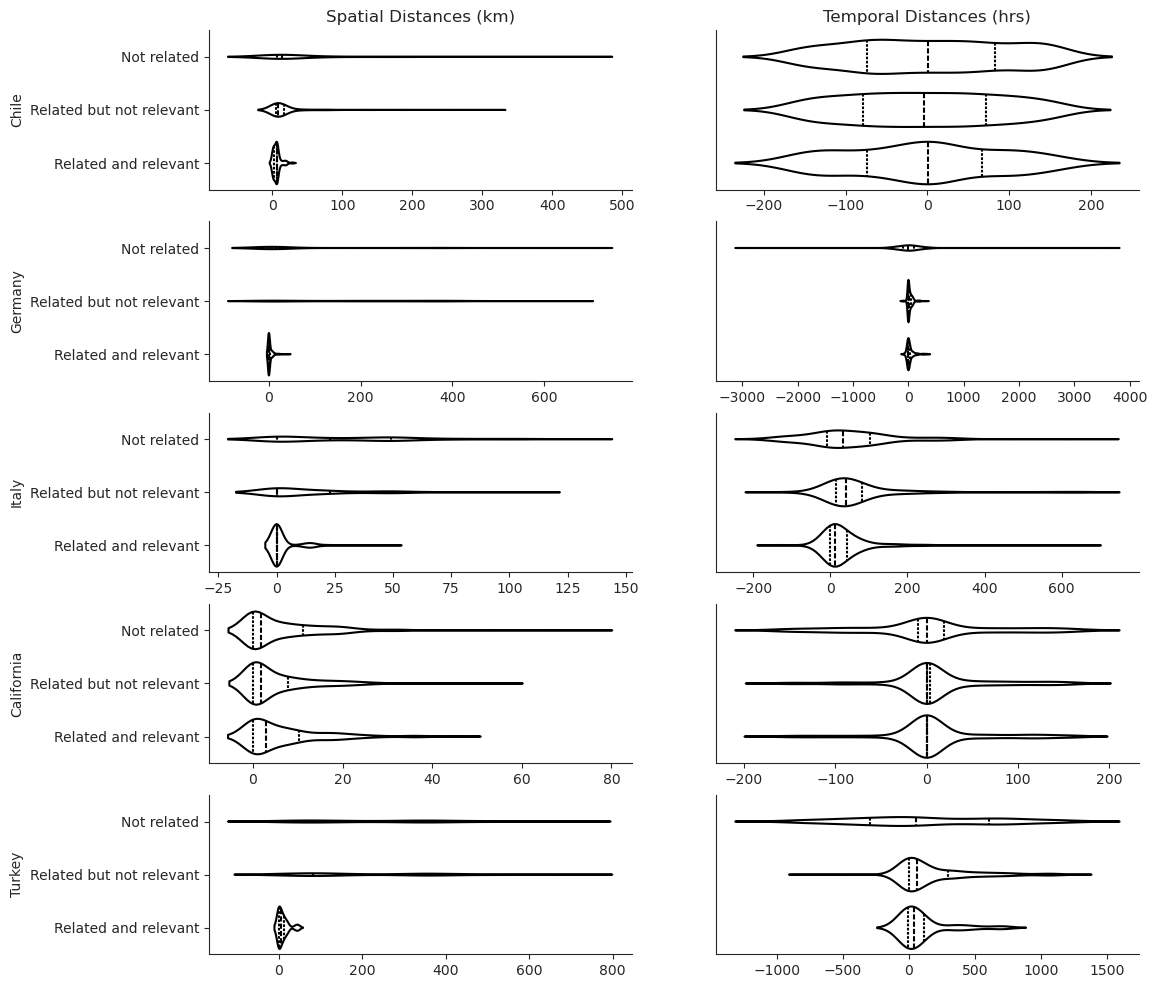

In [39]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

for i, use_case in enumerate(relevance_tweets['use_case'].unique()):
    subset: gpd.GeoDataFrame = relevance_tweets[relevance_tweets['use_case'] == use_case].copy()
    subset.sort_values(by=[LABEL_COLUMN], key=lambda x: x.map({'Not related': 0, 'Related but not relevant': 1, 'Related and relevant': 2}), inplace=True)

    sns.violinplot(data=subset, y=LABEL_COLUMN, x='event_distance_km', ax=axs[i, 0], inner="quart", fill=False, color='k')
    sns.violinplot(data=subset, y=LABEL_COLUMN, x='event_distance_h', ax=axs[i, 1], inner="quart", fill=False, color='k')
    axs[i,1].get_yaxis().set_visible(False)
    axs[i,1].set_xlabel('')
    axs[i,0].set_xlabel('')
    axs[i,0].set_ylabel(use_case[:-2])
axs[0,0].set_title('Spatial Distances (km)')
axs[0,1].set_title('Temporal Distances (hrs)')
sns.despine()

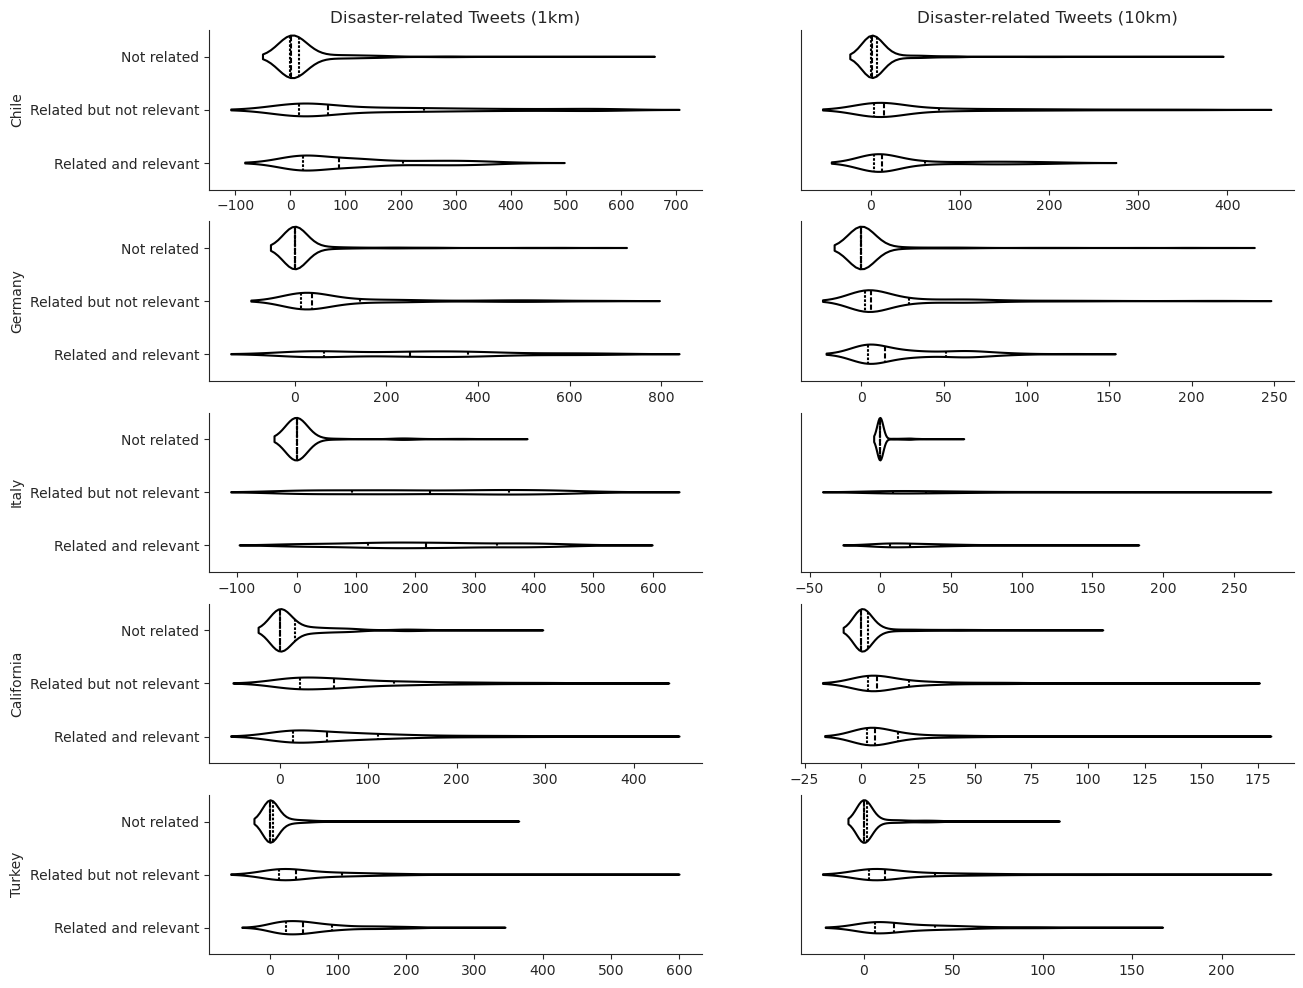

In [36]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,12))

for i, use_case in enumerate(relevance_tweets['use_case'].unique()):
    subset: gpd.GeoDataFrame = relevance_tweets[relevance_tweets['use_case'] == use_case].copy()
    subset.sort_values(by=[LABEL_COLUMN], key=lambda x: x.map({'Not related': 0, 'Related but not relevant': 1, 'Related and relevant': 2}), inplace=True)

    sns.violinplot(data=subset, y=LABEL_COLUMN, x='n_disaster_tweets_50km', ax=axs[i, 0], inner="quart", fill=False, color='k',
                   edgecolor='k')
    sns.violinplot(data=subset, y=LABEL_COLUMN, x='n_disaster_tweets_10km', ax=axs[i, 1], inner="quart", fill=False, color='k',
                   edgecolor='k')
    axs[i,1].get_yaxis().set_visible(False)
    # axs[i,2].get_yaxis().set_visible(False)
    # axs[i,2].set_xlabel('')
    axs[i,1].set_xlabel('')
    axs[i,0].set_xlabel('')
    axs[i,0].set_ylabel(use_case[:-2])
axs[0,0].set_title('Disaster-related Tweets (1km)')
axs[0,1].set_title('Disaster-related Tweets (10km)')
sns.despine()
    